# Import packages

In [25]:
import pandas as pd
from teradataml import *
import ast
import json
import matplotlib.pyplot as plt


from utils import clean_text
from constants import (

JIO_MART_DATASET_MAPPED, MWPD_FULL_DATASET, USDA_TO_CPG, EXTRA_FOOD_DATA, MANUALLY_LABELLED_DATASET, JIO_MART_DATASET
)


In [ ]:
def preprocess_keep_symbols(text):
    if pd.isna(text): return ""
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'[^a-z0-9\s\+\-/\.]', ' ', text)
    return ' '.join(text.split())

## MWPD Dataset

In [3]:
mwpd_df = pd.read_csv(MWPD_FULL_DATASET)
mwpd_df.head()

,Name,Description,SegmentTitle,FamilyTitle,ClassTitle
0,Sterling Silver Angel Charm,This little angel charm is just heavenly,64000000_Personal Accessories,64010000_Personal Accessories,64010100_Jewellery
1,HP Pavilion 23xi 58.40 cm (23�) IPS Monitor,"Share photos, videos, and games with everyone ...",65000000_Computing,65010000_Computers/Video Games,65010700_Computer/Video Game Peripherals
2,East Carolina Pirates Ladies Personalized Bask...,Feel like a bona fide member of East Carolina ...,67000000_Clothing,67010000_Clothing,67010800_Upper Body Wear/Tops
3,"Tekonsha 90195 P3 Electric Brake Control, 1-4 ...",Receive free shipping on this item. Enter coup...,77000000_Automotive,77010000_Automotive Accessories and Maintenance,77011200_Automotive Maintenance/Repair
4,RN-XV WiFly Module - Wire Antenna,Description: The RN-XV module by Roving Networ...,78000000_Electrical Supplies,78050000_Electronic Communication Components,78050100_Electronic Communication Components


In [9]:
mwpd_df = mwpd_df.applymap(preprocess_keep_symbols)

C:\Users\ss255385\AppData\Local\Temp\ipykernel_5096\767690336.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mwpd_df = mwpd_df.applymap(preprocess_keep_symbols)


In [10]:
mwpd_df.isna().sum()

Name            0
Description     0
SegmentTitle    0
FamilyTitle     0
ClassTitle      0
dtype: int64

In [11]:
for col in ["SegmentTitle", "FamilyTitle", "ClassTitle"]:
    print(f"Unique {col}: {mwpd_df[col].nunique()}")

Unique SegmentTitle: 37
Unique FamilyTitle: 76
Unique ClassTitle: 283


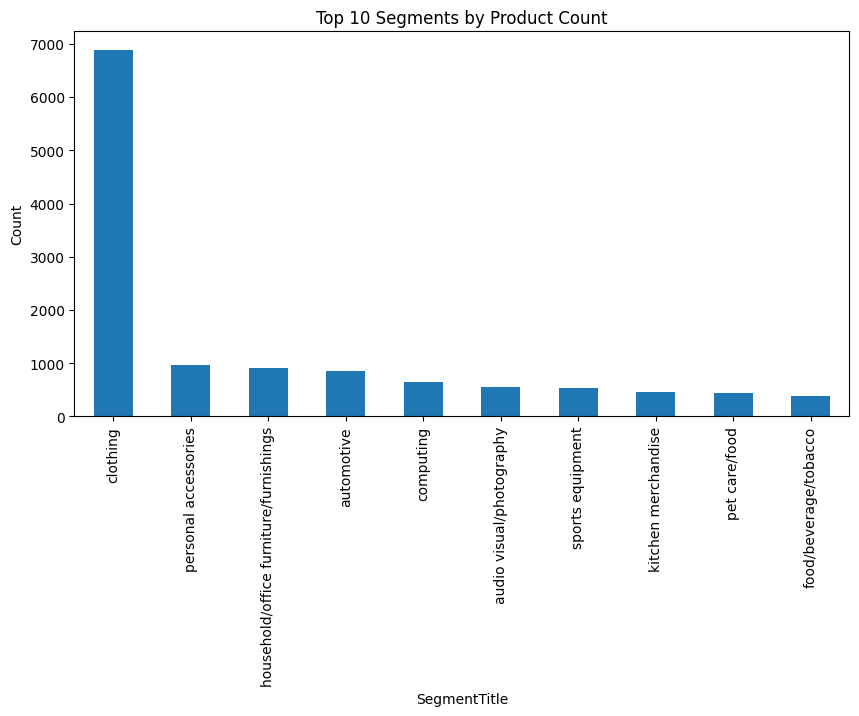

In [12]:
plt.figure(figsize=(10,5))
mwpd_df["SegmentTitle"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Segments by Product Count")
plt.ylabel("Count")
plt.show()

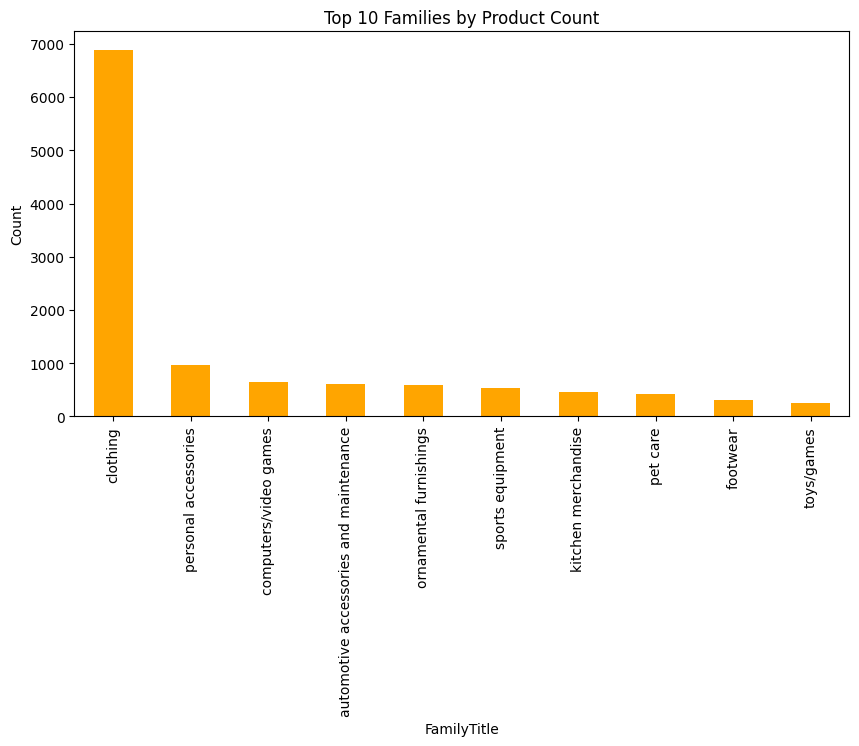

In [13]:
plt.figure(figsize=(10,5))
mwpd_df["FamilyTitle"].value_counts().head(10).plot(kind="bar", color="orange")
plt.title("Top 10 Families by Product Count")
plt.ylabel("Count")
plt.show()

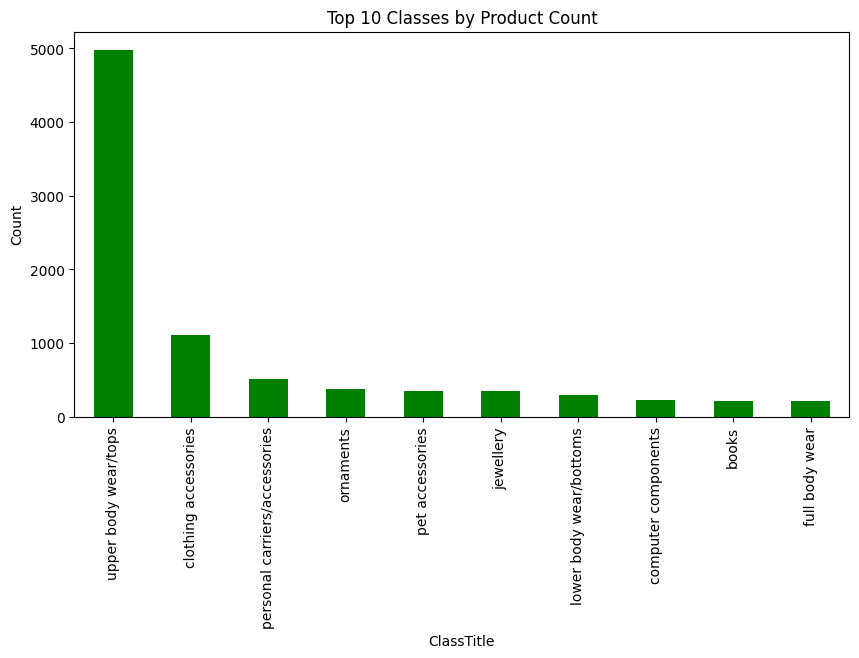

In [14]:
plt.figure(figsize=(10,5))
mwpd_df["ClassTitle"].value_counts().head(10).plot(kind="bar", color="green")
plt.title("Top 10 Classes by Product Count")
plt.ylabel("Count")
plt.show()

In [8]:
seg_fam = mwpd_df.groupby("FamilyTitle")["SegmentTitle"].nunique()
print("\nFamilies mapping to multiple Segments:", (seg_fam > 1).sum())


Families mapping to multiple Segments: 0


In [9]:
fam_cls = mwpd_df.groupby("ClassTitle")["FamilyTitle"].nunique()
print("Classes mapping to multiple Families:", (fam_cls > 1).sum())

Classes mapping to multiple Families: 1


In [19]:
print("\nProducts per Segment (top 5):")
mwpd_df.groupby("SegmentTitle")["Name"].count().sort_values(ascending=False).head(5)


Products per Segment (top 5):


SegmentTitle
clothing                                  6887
personal accessories                       962
household/office furniture/furnishings     910
automotive                                 846
computing                                  642
Name: Name, dtype: int64

In [20]:
print("\nProducts per Segment (lower 5):")
mwpd_df.groupby("SegmentTitle")["Name"].count().sort_values(ascending=False).tail(5)


Products per Segment (lower 5):


SegmentTitle
horticulture plants           26
storage/haulage containers    18
fuels/gases                    7
tool storage/workshop aids     6
lubricants                     2
Name: Name, dtype: int64

In [21]:
print("\nProducts per Family (top 5):")
mwpd_df.groupby("FamilyTitle")["Name"].count().sort_values(ascending=False).head(5)


Products per Family (top 5):


FamilyTitle
clothing                                  6887
personal accessories                       962
computers/video games                      642
automotive accessories and maintenance     617
ornamental furnishings                     595
Name: Name, dtype: int64

In [22]:
print("\nProducts per Family (lower 5):")
mwpd_df.groupby("FamilyTitle")["Name"].count().sort_values(ascending=False).tail(5)


Products per Family (lower 5):


FamilyTitle
stationery/office machinery/occasion supplies variety packs    3
waste management products                                      3
live plants genus a thru g                                     2
lubricants/protective compounds                                2
plants variety packs                                           2
Name: Name, dtype: int64

In [23]:
print("\nProducts per Class (top 5):")
mwpd_df.groupby("ClassTitle")["Name"].count().sort_values(ascending=False).head(5)


Products per Class (top 5):


ClassTitle
upper body wear/tops             4979
clothing accessories             1109
personal carriers/accessories     513
ornaments                         370
pet accessories                   350
Name: Name, dtype: int64

In [24]:
print("\nProducts per Class (lower 5):")
mwpd_df.groupby("ClassTitle")["Name"].count().sort_values(ascending=False).tail(5)


Products per Class (lower 5):


ClassTitle
role play toys                             1
beverages variety packs                    1
automotive trailers/trailer accessories    1
tools/equipment hand variety packs         1
toys/games variety packs                   1
Name: Name, dtype: int64

## Jio Mart

In [26]:
jio_mart_df = pd.read_csv(JIO_MART_DATASET)
jio_mart_df = jio_mart_df.loc[~jio_mart_df['items'].isna(), :]
jio_mart_df = jio_mart_df.drop(columns=['href', 'price'])
jio_mart_df.rename(columns={'items': 'product name'}, inplace=True)
jio_mart_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162280 entries, 0 to 162312
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      162280 non-null  object
 1   sub_category  162280 non-null  object
 2   product name  162280 non-null  object
dtypes: object(3)
memory usage: 5.0+ MB


In [28]:
jio_mart_df_cateogires = jio_mart_df["category"].nunique()
jio_mart_df_cateogires

6

In [29]:
jio_mart_df_sub_cateogires = jio_mart_df["sub_category"].nunique()
jio_mart_df_sub_cateogires

69

In [30]:
jio_mart_df.isna().sum()

category        0
sub_category    0
product name    0
dtype: int64

In [44]:
jio_mart_df_mapped = pd.read_csv(JIO_MART_DATASET_MAPPED)

In [45]:
jio_mart_df_mapped.head()

,category,sub_category,product name,Segment,Family,Class,Brick
0,Groceries,Fruits & Vegetables,Fresh Dates (Pack) (Approx 450 g - 500 g),Food/Beverage,Fruits/Vegetables Fresh Cut,NaN,NaN
1,Groceries,Fruits & Vegetables,Tender Coconut Cling Wrapped (1 pc) (Approx 90...,Food/Beverage,Fruits/Vegetables Fresh Cut,NaN,NaN
2,Groceries,Fruits & Vegetables,Mosambi 1 kg,Food/Beverage,Fruits/Vegetables Fresh Cut,NaN,NaN
3,Groceries,Fruits & Vegetables,Orange Imported 1 kg,Food/Beverage,Fruits/Vegetables Fresh Cut,NaN,NaN
4,Groceries,Fruits & Vegetables,Banana Robusta 6 pcs (Box) (Approx 800 g - 110...,Food/Beverage,Fruits/Vegetables Fresh Cut,NaN,NaN


In [ ]:
# jio_mart_df_mapped = jio_mart_df_mapped.applymap(preprocess_keep_symbols)

C:\Users\ss255385\AppData\Local\Temp\ipykernel_5096\3092287498.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  jio_mart_df_mapped = jio_mart_df_mapped.applymap(preprocess_keep_symbols)


In [46]:
for col in ["category", "sub_category"]:
    print(f"Unique {col}: {jio_mart_df_mapped[col].nunique()}")

Unique category: 6
Unique sub_category: 69


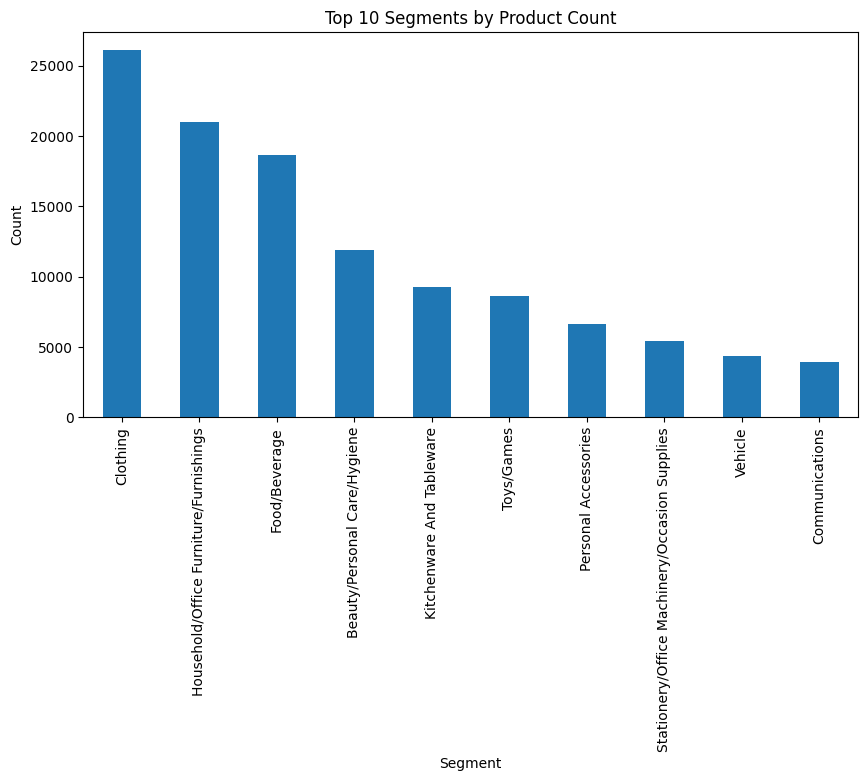

In [47]:
plt.figure(figsize=(10,5))
jio_mart_df_mapped["Segment"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Segments by Product Count")
plt.ylabel("Count")
plt.show()

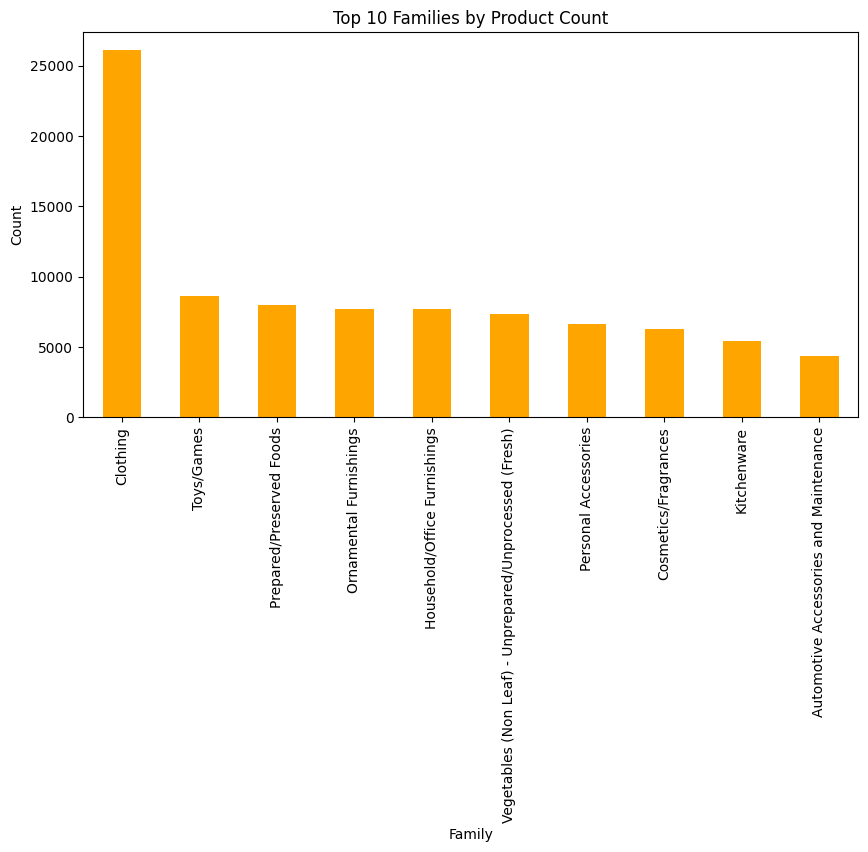

In [48]:
plt.figure(figsize=(10,5))
jio_mart_df_mapped["Family"].value_counts().head(10).plot(kind="bar", color="orange")
plt.title("Top 10 Families by Product Count")
plt.ylabel("Count")
plt.show()

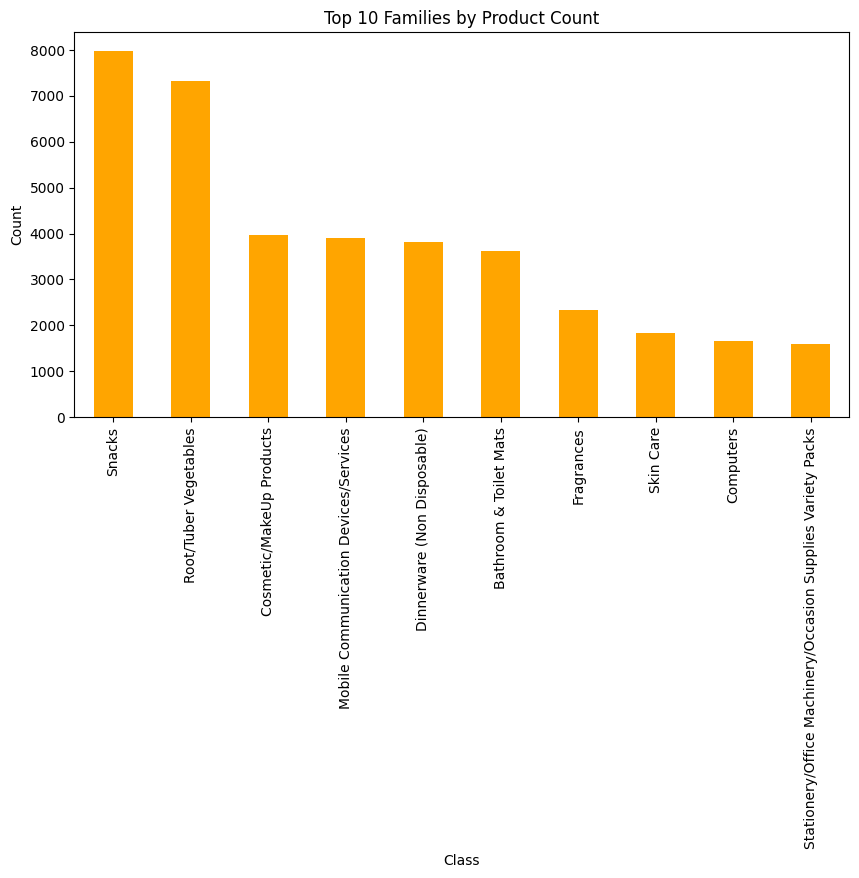

In [49]:
plt.figure(figsize=(10,5))
jio_mart_df_mapped["Class"].value_counts().head(10).plot(kind="bar", color="orange")
plt.title("Top 10 Families by Product Count")
plt.ylabel("Count")
plt.show()